# Analysing a PPG signal

In this notebook we'll go over how to analyse a regular PPG signal. We will take two examples, a very clean PPG signal, a noisy PPG signal from a smart. (*Acknowledgement: The notebook and datasets are based on HeartPy, a Python-based Heart Rate Analysis toolkit*)

In [1]:
#First let's import
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams.update({'font.size': 12})

# enable zooming into graphs
%matplotlib notebook

There's four datasets that we will look at in this notebook:
- 0 : a short, very clean PPG signal, sampled at 100.0 Hz
- 1 : a slightly longer (~2 minute) PPG signal sampled at 100Hz, with missing signal in first third, and random noise spikes in rest of signal. This is a more tricky signal. There's no signal in the beginning as recording started before and while putting on the sensor. After the signal commences there's a few noise spikes as the sensor is moved while recording. This imitates what may happen when recording 'in the wild' as well if the participant moves and accidentally tugs at a sensor cable.
- 2 : a slightly longer (~4 minute) PPG signal taken from a commercial (Samsung) smartwatch device with intermittent sections of PPG dotted between non-signals (periods where the sensor was not recording). A signal measured this way contains a lot more noise when compared to a typical PPG sensor on the fingertip or earlobe, where perfusion is much easier to measure than on the wrist. The signal is sampled at 10 Hz.
- 3 : a long (~11.5 minute) PPG signal recorded 'in the wild' while driving in a driving simulator using a Pulse Sensor on the index finger and an Arduino. The signal is sampled at 32 Hz.

---------

You can go through all examples and analyze each one to see how they look and how to filter them to determine heartrate.

<IPython.core.display.Javascript object>


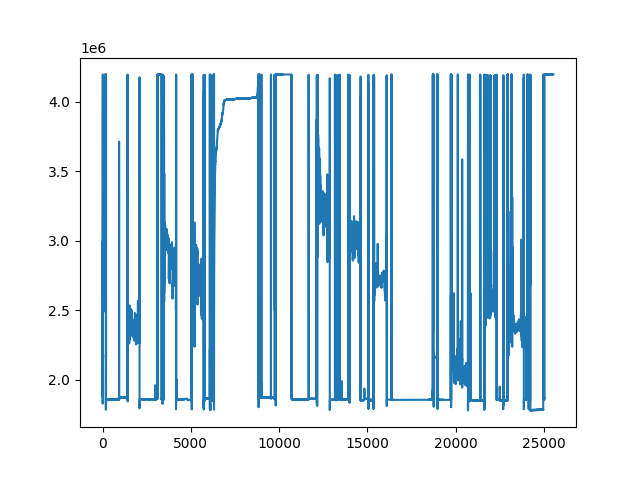

In [10]:
#first let's load the PPG signal

# log_filename = 'data/clean_ppg_data.csv'; SAMPLING_RATE = 100
# log_filename = 'data/noisy_ppg_data.csv'; SAMPLING_RATE = 100
log_filename = 'data/smartwatch_ppg_data.csv'; SAMPLING_RATE = 10;
# log_filename = 'data/smartring_ppg_data.csv'; SAMPLING_RATE = 32

data = np.loadtxt(log_filename, delimiter=',', unpack=True, skiprows=0)

#and visualise
dt = 1/SAMPLING_RATE
DURATION = len(data)*dt
timestamp = np.arange(0,DURATION,dt)

plt.figure()
plt.plot(timestamp,data)
plt.show()

<IPython.core.display.Javascript object>


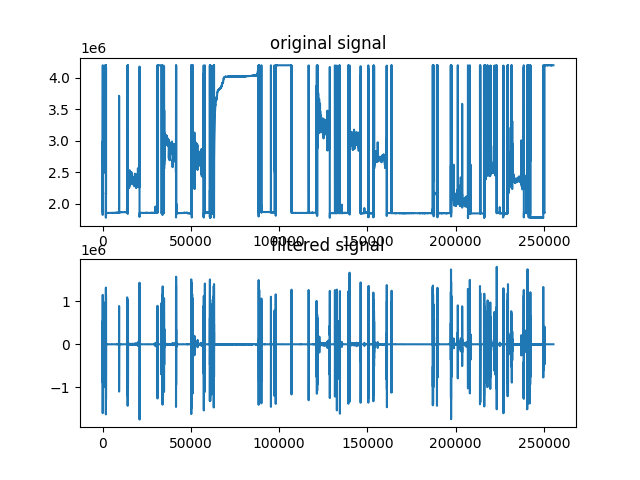

In [11]:
from scipy.signal import butter, lfilter

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y 

#Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
#The filtering step is not required for the clean dataset but needed for the more noisy data from smartwatch/ring.
filtered = butter_bandpass_filter(data, 0.7, 3.5, SAMPLING_RATE)

#let's plot the filtered vs noisy data to visualize!
plt.figure()
plt.subplot(211)
plt.plot(data)
plt.title('original signal')
plt.subplot(212)
plt.plot(filtered)
plt.title('filtered signal')
plt.show()

<IPython.core.display.Javascript object>


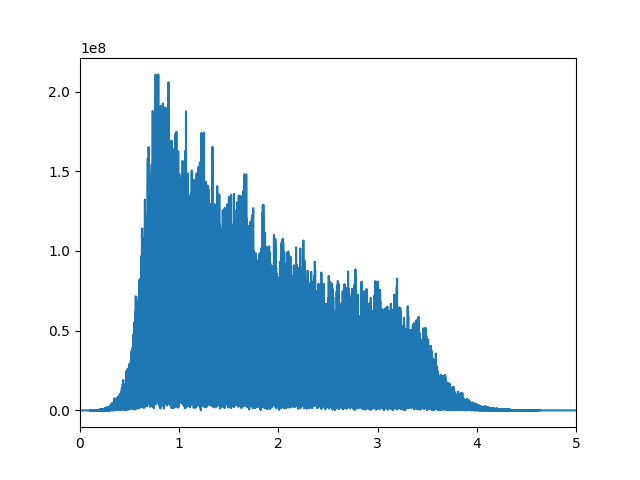

In [12]:
from scipy.fft import rfft, rfftfreq

## Compute the Fast Fourier Transform (FFT)
N = len(filtered)
yf = rfft(filtered,N)                     # Compute the FFT
xf = rfftfreq(N,1/SAMPLING_RATE)

yf[0] = 0 # Remove the mean

plt.figure()
plt.plot(xf, np.abs(yf))
plt.xlim([0, 5])
plt.show()

### Analyzing the signal with FFT

Lets see if we can extract heart rate by taking the Fast Fourier Transform (FFT) of the PPG signal and simply looking for the tallest frequency peak.

<IPython.core.display.Javascript object>


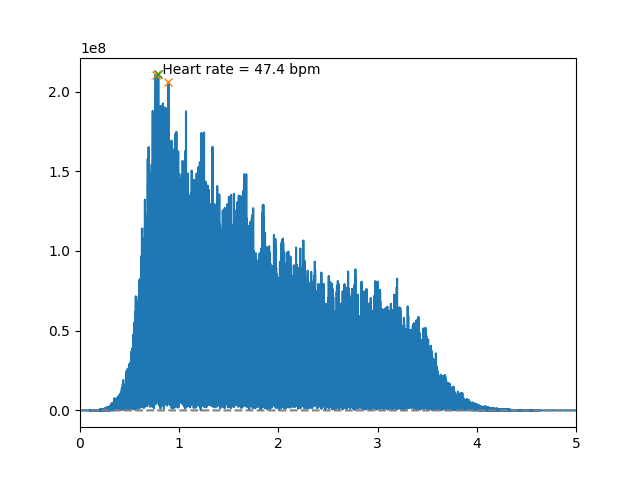

In [13]:
from scipy.signal import find_peaks

yf = np.abs(yf)

idx = np.argpartition(yf, -3)[-3:]  # Indices not sorted
idx = idx[np.argsort(yf[idx])][::-1]  # Indices sorted by value from largest to smallest

hr = idx[0]
plt.figure()
plt.plot(xf,yf)
plt.plot(xf[idx], yf[idx], "x")
plt.annotate(' Heart rate = ' + "{:.1f}".format(xf[hr]*60) + ' bpm', (xf[hr], yf[hr]))
plt.plot(xf[hr],yf[hr],"x")
plt.plot(xf,np.zeros_like(yf), "--", color="gray")
plt.xlim([0, 5])
plt.show()

### Conclusion

Now you know how PPG signals from wearable devices look and how to analyze them and remove noise. 
